In [38]:

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import joblib

In [39]:
df = pd.read_csv("/home/user/veridia.io/code/model1(distillbert)/resume_cleaned.csv")
print(f"✅ Loaded {len(df)} resumes")
df = df.dropna(subset=['advanced_cleaned_text'])
texts = df['advanced_cleaned_text'].astype(str).tolist()
labels = df['Category'].astype(str).tolist()

✅ Loaded 2481 resumes


In [40]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
joblib.dump(label_encoder, "label_encoder.pkl")
print("✅ Label encoder saved (label_encoder.pkl)")

✅ Label encoder saved (label_encoder.pkl)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

Train size: 1984 | Test size: 497


In [36]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_dataset = Dataset.from_pandas(train_df[["advanced_cleaned_text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["advanced_cleaned_text", "label"]])
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")


Train size: 1984 | Test size: 497


In [49]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(
    X_train, truncation=True, padding=True, max_length=512
)
test_encodings = tokenizer(
    X_test, truncation=True, padding=True, max_length=512
)

class ResumeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ResumeDataset(train_encodings, y_train)
test_dataset = ResumeDataset(test_encodings, y_test)


In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device set to use {device}")

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(np.unique(y_train))
)

Device set to use cuda


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 466c3e47-1116-4509-bda0-6f209edbaa2c)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

training_args = TrainingArguments(
    output_dir="models/distilbert_resume",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=9,
    weight_decay=0.01,
    report_to="none",
    load_best_model_at_end=True
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = weighted_loss(labels, outputs.logits)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model("models/final_distilbert_resume")
print("✅ Model saved successfully!")


📊 Classification Report:

                        precision    recall  f1-score   support

            ACCOUNTANT       0.89      1.00      0.94        24
              ADVOCATE       0.84      0.88      0.86        24
           AGRICULTURE       0.65      0.85      0.73        13
               APPAREL       0.92      0.58      0.71        19
                  ARTS       0.64      0.67      0.65        21
            AUTOMOBILE       0.60      0.43      0.50         7
              AVIATION       1.00      0.91      0.95        23
               BANKING       0.86      0.83      0.84        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.92      1.00      0.96        24
                  CHEF       0.90      0.79      0.84        24
          CONSTRUCTION       1.00      0.95      0.98        22
            CONSULTANT       0.95      0.83      0.88        23
              DESIGNER       0.90      0.90      0.90        21
         DIG

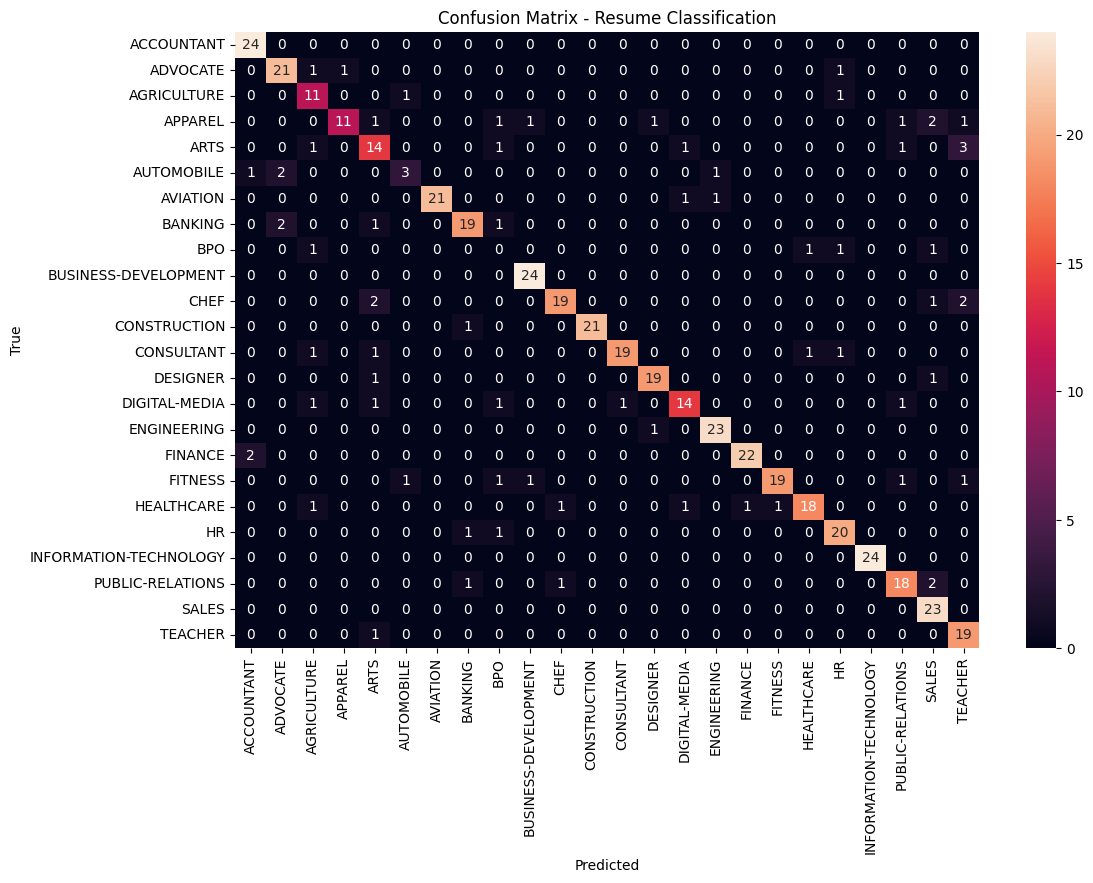

In [68]:
preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=-1)

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Resume Classification")
plt.show()


In [83]:
def predict_resume_category(text, target_confidence=0.85, max_temp=2.0, step=0.05):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    temperature = 1.0  # start with normal softmax

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Iteratively reduce temperature until desired confidence is reached
        while temperature > 0.05:
            scaled_logits = logits / temperature
            probs = torch.nn.functional.softmax(scaled_logits, dim=-1)
            pred_label = torch.argmax(probs, dim=1).item()
            confidence = probs[0][pred_label].item()
            if confidence >= target_confidence or temperature >= max_temp:
                break
            temperature -= step

        category = label_encoder.inverse_transform([pred_label])[0]

    print(f"\n🧾 Predicted Category: {category}")
    print(f"📊 Confidence: {confidence:.4f} (Temperature={temperature:.2f})")
    return {"category": category, "confidence": confidence}

# Example usage
predict_resume_category("Experienced in React.js, Node.js, and building web applications.")




🧾 Predicted Category: INFORMATION-TECHNOLOGY
📊 Confidence: 0.8637 (Temperature=0.70)


{'category': np.str_('INFORMATION-TECHNOLOGY'),
 'confidence': 0.8636812567710876}

In [85]:
joblib.dump(label_encoder, "label_encoder.pkl")
print("✅ Label encoder saved as 'label_encoder.pkl'")

✅ Label encoder saved as 'label_encoder.pkl'
